In [9]:
from functions import *
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
from optparse import OptionParser
import matplotlib
matplotlib.use('Agg')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping

%matplotlib inline

#min_max_scaler = MinMaxScaler()
n_iter = 100

chunk = 'S8'
print (chunk)

data, labels, unique_mutations[chunk], aa_seq, mut_list = read_data_all_positions(chunk)

print 'Splitting the data'
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size = 0.05)

n_neurons = []

mse_val = []
mse_train = []
r_val=[]
r_train=[]

r2_weights = []

for i in range(2,3):
    
    print '\nNumber of weights combinations = ', i
    temp_mse_train_list=[]
    temp_mse_val_list=[]
    temp_r_train_list=[]
    temp_r_val_list=[]
    temp_weights_r2={}
    it=0
    loop_count=1
    
    while it<loop_count and loop_count<100:
        print it
        model = Sequential()

        model.add(Dense(i,input_dim=data.shape[1],activation='sigmoid',kernel_initializer='glorot_normal'))
        model.add(Dense(20,activation='sigmoid'))
        model.add(Dense(1,activation='relu'))

        opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
        
        early_stopping_monitor=EarlyStopping(patience=10)
        
        model.compile(optimizer=opt,
                      loss='mean_squared_error')

        hist = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                                epochs=n_iter, batch_size=500, shuffle=True, callbacks=[early_stopping_monitor],verbose=1)

        proba = model.predict_proba(x_valid, batch_size=500,verbose=0)
        predicted_val = proba.flatten()

        proba = model.predict_proba(x_train, batch_size=500,verbose=0)
        predicted_train = proba.flatten()
        
        weights = model.layers[0].get_weights()[0]
        
        temp_mse_val = mean_squared_error(y_valid,predicted_val)
        temp_mse_train = mean_squared_error(y_train,predicted_train)
        temp_r_val = pearsonr(y_valid,predicted_val)[0]
        temp_r_train = pearsonr(y_train,predicted_train)[0]
        
        it+=1
        
        #Sanity checks
        if temp_mse_val<0.1:
            temp_mse_val_list.append(temp_mse_val)
            temp_mse_train_list.append(temp_mse_train)
            temp_r_val_list.append(temp_r_val)
            temp_r_train_list.append(temp_r_train)
            
            for combination in list(itertools.combinations([x for x in range(i)], 2)):
                if combination in temp_weights_r2:
                    temp_weights_r2[combination].extend([spearmanr(weights[:,combination[0]],weights[:,combination[1]])])
                else:
                    temp_weights_r2[combination] = [spearmanr(weights[:,combination[0]],weights[:,combination[1]])]
                    
        else:
            loop_count+=1
                    
                    
    n_neurons.append(i)
    mse_val.append(temp_mse_val_list)
    mse_train.append(temp_mse_train_list)
    r_val.append(temp_r_val_list)
    r_train.append(temp_r_train_list)
    
    if i>1:
        r2_weights.append([np.median(temp_weights_r2[x]) for x in temp_weights_r2])

S8
Splitting the data

Number of weights combinations =  2
0
Train on 43991 samples, validate on 2316 samples
Epoch 1/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 2/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 3/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 4/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 5/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 6/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 7/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 8/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 9/100
43991/43991 [==============================] - 0s - loss: 0.2164 - val_loss: 0.2146
Epoch 10/100
43991/43991 [

$F(x) = \sigma(\sum_{i=1}^{20}c_{3,i}\sigma(c_{2,i}\sigma(c_1^Tx + b_1) + b_{2,i}))$

In [10]:
fp = x_valid.dot(weights)

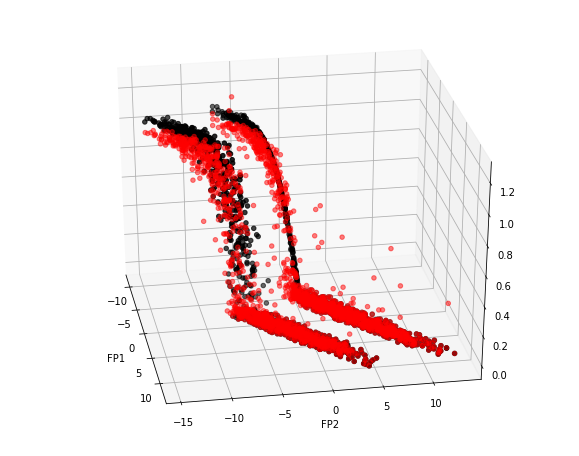

In [11]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fp[:,0],fp[:,1],predicted_val,color='k')
ax.scatter(fp[:,0],fp[:,1],y_valid,color='r',alpha=0.5)
plt.xlabel('FP1')
plt.ylabel('FP2')

# for angle in range(0, 360, 10):
ax.view_init(30, 350)
plt.draw()
#     plt.savefig('../3d/'+str(angle)+'.png')

In [17]:
one_curve=[]

for i in [np.where((fp[:,0]<0)&(fp[:,1]>0))][0][0]:
    for mut in mut_list[i].split(':'):
        one_curve.append(mut)
        
for i in [np.where((fp[:,0]>0)&(fp[:,1]>5))][0][0]:
    for mut in mut_list[i].split(':'):
        one_curve.append(mut)

In [22]:
other_curve=[]

for i in [np.where((fp[:,0]<0)&(fp[:,1]<-1))][0][0]:
    for mut in mut_list[i].split(':'):
        other_curve.append(mut)
        
for i in [np.where((fp[:,0]>0)&(fp[:,1]<5))][0][0]:
    for mut in mut_list[i].split(':'):
        other_curve.append(mut)

In [26]:
other_curve_dict=FreqDist(other_curve)
one_curve_dict=FreqDist(one_curve)

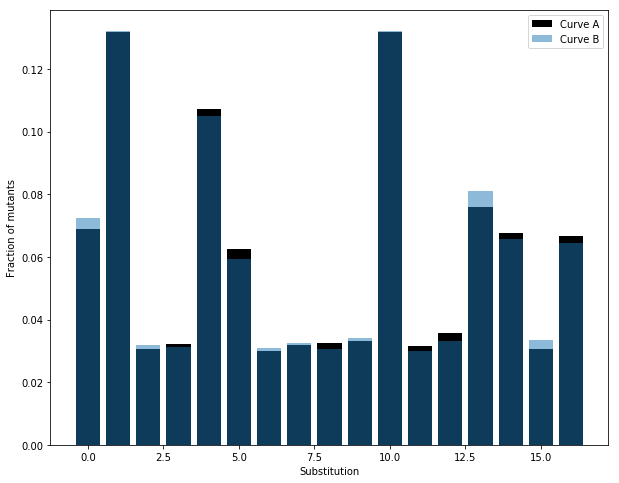

In [40]:
plt.figure(figsize=[10,8])
plt.bar([x for x in range(len(one_curve_dict.keys()))],[x*1./sum(one_curve_dict.values()) for x in one_curve_dict.values()],color='black',label='Curve A')
plt.bar([x for x in range(len(other_curve_dict.keys()))],[x*1./sum(other_curve_dict.values()) for x in other_curve_dict.values()],alpha=0.5,label='Curve B')
plt.legend()
plt.xlabel('Substitution')
plt.ylabel('Fraction of mutants')


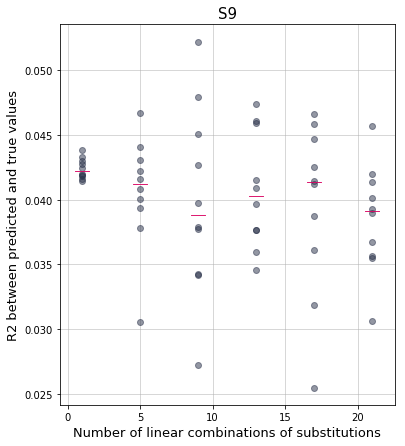

In [21]:

plt.figure(figsize=[6,7])
for i,r_list in enumerate(r_val):
    plt.plot([i*4+1]*len(r_list),[float(x)**2 for x in r_list],'o',alpha=0.5,color='#283149')
    plt.plot([i*4+0.5,i*4+1.5],[np.median([float(x)**2 for x in r_list])]*2,'-',lw=0.9,color='#DA0463')
plt.grid('--k',lw=0.5)
plt.title(chunk,fontsize=15)
plt.ylabel('R2 between predicted and true values',fontsize=13)
plt.xlabel('Number of linear combinations of substitutions',fontsize=13)
plt.savefig('/nfs/scistore08/kondrgrp/eputints/Jupyter/HIS3InterspeciesEpistasis/Analysis/Katya/NN/complexity/20_iterations/r_'+chunk+'.pdf')

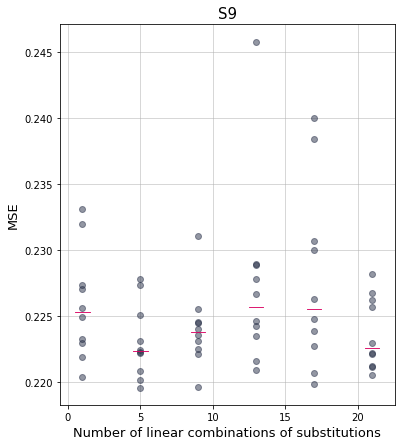

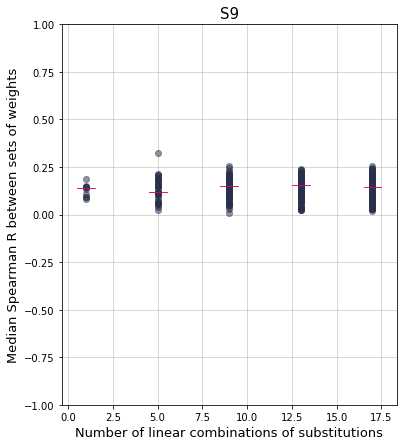

In [22]:
plt.figure(figsize=[6,7])
for i,mse_list in enumerate(mse_val):
    plt.plot([i*4+1]*len(mse_list),mse_list,'o',alpha=0.5,color='#283149')
    plt.plot([i*4+0.5,i*4+1.5],[np.median(mse_list)]*2,'-',lw=0.9,color='#DA0463')
plt.grid('--k',lw=0.5)
plt.title(chunk,fontsize=15)
plt.ylabel('MSE',fontsize=13)
plt.xlabel('Number of linear combinations of substitutions',fontsize=13)
plt.savefig('/nfs/scistore08/kondrgrp/eputints/Jupyter/HIS3InterspeciesEpistasis/Analysis/Katya/NN/complexity/20_iterations/mse_'+chunk+'.pdf')

plt.figure(figsize=[6,7])
for i,r2_list in enumerate(r2_weights):
    plt.plot([i*4+1]*len(r2_list),r2_list,'o',alpha=0.5,color='#283149')
    plt.plot([i*4+0.5,i*4+1.5],[np.median(r2_list)]*2,'-',lw=0.9,color='#DA0463')
plt.ylim(-1,1)
plt.title(chunk,fontsize=15)
plt.grid('--k',lw=0.5)
plt.ylabel('Median Spearman R between sets of weights',fontsize=13)
plt.xlabel('Number of linear combinations of substitutions',fontsize=13)
plt.savefig('/nfs/scistore08/kondrgrp/eputints/Jupyter/HIS3InterspeciesEpistasis/Analysis/Katya/NN/complexity/20_iterations/r2_weights_'+chunk+'.pdf')

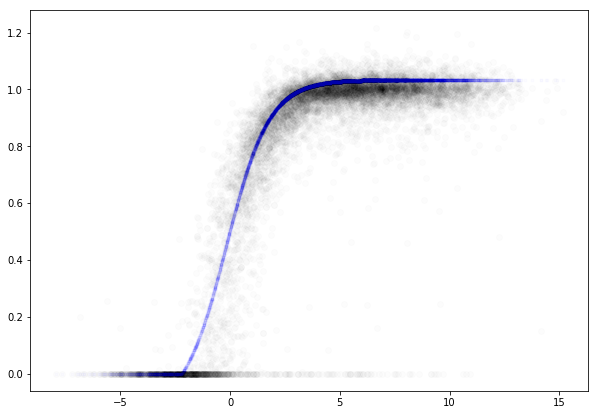

In [52]:
fitness_potential = x_train.dot(weights)+biases
plt.figure(figsize = [10,7])
plt.plot(fitness_potential[:10000], y_train[:10000], 'ok', alpha = 0.01);
plt.plot(fitness_potential[:10000], predicted_train[:10000], '.b', alpha = 0.01);

In [48]:
x=[]
y=[]
for i,l in enumerate(mse_val):

        x.extend([i*3+1]*len(l))
        y.extend(l)

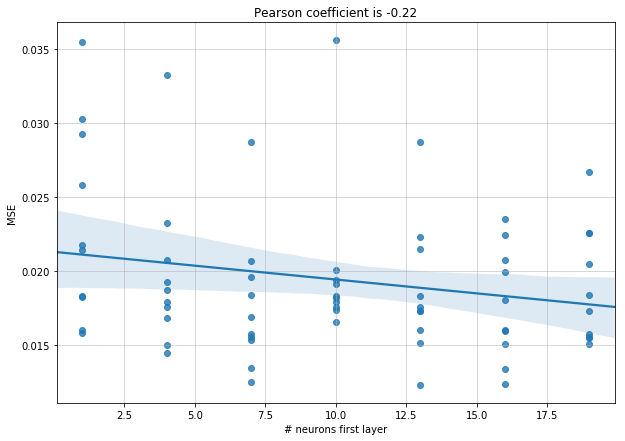

In [49]:
plt.figure(figsize=[10,7])
sns.regplot(x=np.array(x), y=np.array(y))
plt.grid('--k',lw=.5)
plt.ylabel('MSE')
plt.xlabel('# neurons first layer')
plt.title('Pearson coefficient is %.2f' % pearsonr(x,y)[0])